# Exploratory Data Analysis of the University of Minho's wine quality data set

## Setup and imports

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

from sklearn.model_selection import train_test_split

## The data
The dataset, created by _Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis_ is a research data set with 11 attributes (+ the output). Each row contains the physicochemical properties of a wine along with its _quality_, rated on a scale of 0-10. The data was sourced from the UCI machine learning repository. The overview page can be found [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) and the data file(s) [here](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/)

## Formulating the question

What is the quality of a wine with a certain combination of physicochemical properties

## Read in the data

In [2]:
red_df = pd.read_csv('../data/raw/winequality-red.csv', sep=';')
white_df = pd.read_csv('../data/raw/winequality-white.csv', sep=';')

### Merging the two data sources

We want our model to work for both red and white wines. For this, we merge the two dataframes and use a new column to denote the type of wine :`type`

In [3]:
red_df['type'] = 'red'
white_df['type'] = 'white'

wine_df = pd.concat([red_df, white_df], ignore_index=True)

## Structure and Characteristics of the data

Here, we are looking for the shape, null-counts, number of observations, and datatypes.

In [4]:
wine_df.shape

(6497, 13)

In [5]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
type                    6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


We have 13 colummns in our dataset. That should give us at most 12 features to work with for our predictive model. The dataset has about 6.5k rows, so we do not have any glaring concerns about the size of the dataset available to train our model yet. We don't seem to have any missing values in any of the columns. Finally, we have 11 numeric columns and 1 binary column. Some of the numeric columns like `total sulfur dioxide` and `free sulfur dioxide` seem to have a larger scale than the rest of the features and could require some scaling.

# Target distribution

Let's take a look at the target: `quality`. We are specifically interested in how many classes there are and the distribution

In [7]:
wine_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Though the score is graded on a scale of 0-10, the dataset only has a examples of 7 classes (3 - 9).

### Splitting the data
Before proceeding with the EDA of the features, let's split the data into train and test splits: 

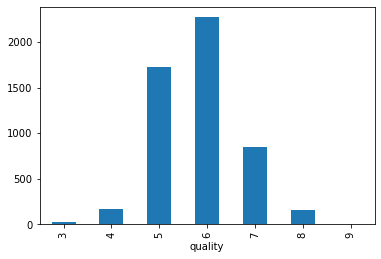

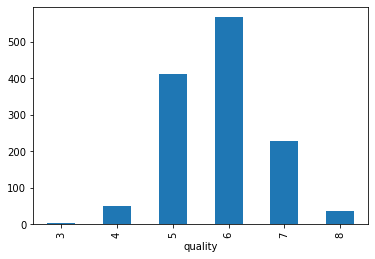

In [8]:
train_df, test_df = train_test_split(wine_df, test_size=0.2, random_state=123)

train_df.quality.groupby(train_df.quality).count().plot.bar()
plt.show()

test_df.quality.groupby(test_df.quality).count().plot.bar()
plt.show()

The class distributions in the test and the train splits are fairly similar. This should let us continue with the EDA with the assurance that our test data is representative of our training set.

## Feature Distributions


### Feature-Target Relationships
To analyze which features might be useful in the prediction of wine quality, we need to take a look at how each feature _differentiates_ between the different classes of data. Below are the distributions of each feature vs the classes, as boxplots. Since boxplots hide the number of observations in each group, the size is encoded with the `count()` of each group.

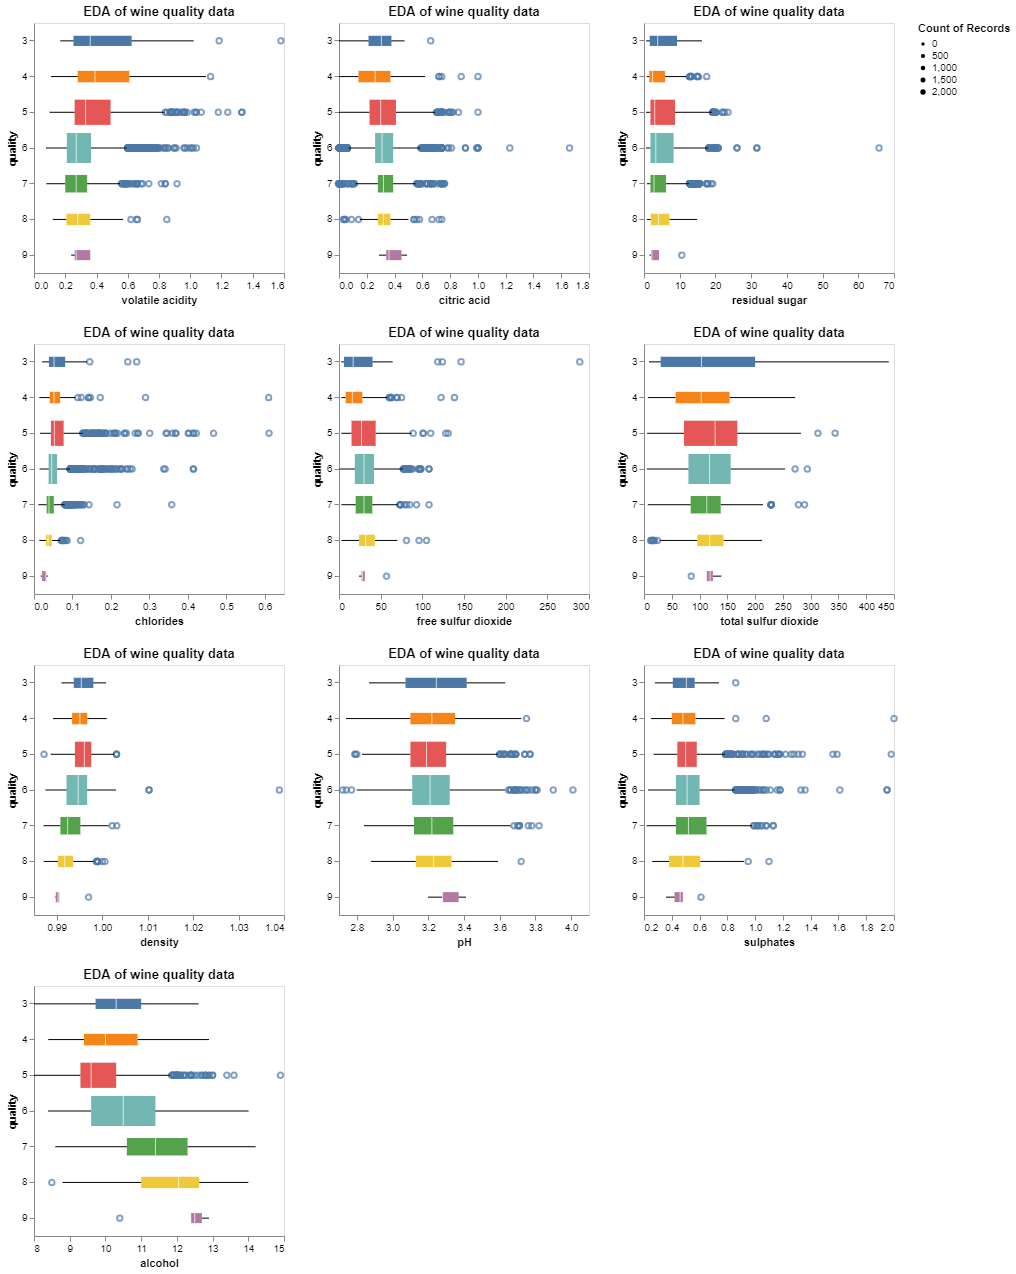

In [9]:
num_cols = list(wine_df.drop(columns=['quality']).select_dtypes(include=np.number).iloc[:,1:].columns)

alt.Chart(train_df, title="EDA of wine quality data").mark_boxplot().encode(
    alt.X(alt.repeat('repeat'), type='quantitative', scale=alt.Scale(zero=False), axis=alt.Axis(grid=False)),
    alt.Y('quality:N', scale=alt.Scale(zero=False), axis=alt.Axis(grid=False)),
    color=alt.Color('quality:N', legend=None),
    size=alt.Size('count()', scale=alt.Scale(range=(10, 30)))
).properties(
    height=250,
    width=250
).repeat(repeat=num_cols, columns = 3)

### Pairwise co-relations

Its also useful to observe any pairwise co-relations for the features. This would help with the choice of the predictive model as well as its evaluation.

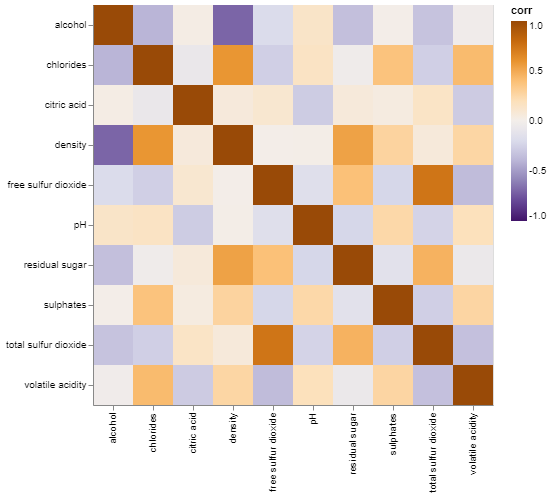

In [10]:
corr_df = train_df[num_cols].corr(method='spearman').stack().reset_index(name='corr')

alt.Chart(corr_df).mark_rect().encode(
    alt.X('level_0', title=''),
    alt.Y('level_1', title=''),
    color=alt.Color('corr', scale=alt.Scale(domain=(-1, 1), scheme='purpleorange')),
    tooltip='corr'
).properties(
    height=400,
    width=400
)

## References

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.<br>
[Modeling wine preferences by data mining from physicochemical properties](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

[Art of Data Science](https://www.amazon.ca/Art-Data-Science-Roger-Peng/dp/1365061469) by Roger Peng & Elizabeth Matsui